mpmath dps = 120
[cache] Loaded primes up to 1000000 (count=78498)
[primes] ready in 0.02s
Cutoffs: [10000, 20000, 50000, 100000, 200000] ... -> 1000000
P=  10000  A_P(φ)≈9.0019874074349603012814277040614326776706420526364940358402859775825160977659506166382977727024332201246792372773378539 -> nearest 9  gap=0.00198740743496030128142770406143267767064205263649403584028597758251609776595061663829777270243322012467923727733785390338
P=  20000  A_P(φ)≈9.00446996995446790573811922163951501859222073443648732340612919916387568838506570502083026179535482001169359649012340201 -> nearest 9  gap=0.00446996995446790573811922163951501859222073443648732340612919916387568838506570502083026179535482001169359649012340200976
P=  50000  A_P(φ)≈9.00634002246850528601194626545709657528900499435324239768409600292437945332322239523168126715251124272002718636002785895 -> nearest 9  gap=0.00634002246850528601194626545709657528900499435324239768409600292437945332322239523168126715251124272002718636002785894707

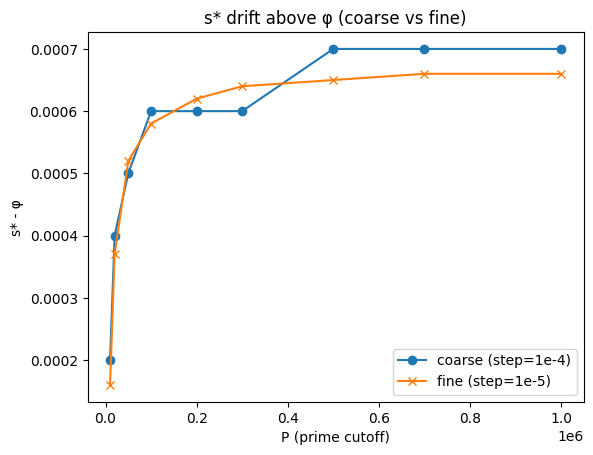

In [1]:
# ================= ONE-CELL: Test B (φ–9) with two-stage s* refinement =================
# - Safe utils/ setup (no stdlib io collision), module cache purge
# - Prime cache build/load
# - Base run at s=phi + coarse grid
# - Two-stage refinement around best s (1e-4 then 1e-5)
# - High precision (120 dps), artifacts + plots

import sys, os, json, csv, pathlib, textwrap, importlib, time

# ----------------------- CONFIG YOU MAY TWEAK -----------------------
MP_DPS_DEFAULT   = 120         # numeric precision (dps)
PRIME_MAX_DEFAULT= 1_000_000   # raise to 2_000_000 if you have time/ram; 10_000_000 will be slow
CUTOFFS          = [10_000, 20_000, 50_000, 100_000, 200_000, 300_000, 500_000, 700_000, 1_000_000]
# Refinement windows (centered near φ):
COARSE_SPAN      = 0.002       # search φ .. φ+0.002 (upward bias expected)
COARSE_STEP      = 1e-4        # 0.0001
FINE_HALF_STEPS  = 15          # +/- 15 steps around coarse best
FINE_STEP        = 1e-5        # 0.00001
# -------------------------------------------------------------------

ROOT = pathlib.Path.cwd().resolve()
PROJECT = ROOT / "math_emergence_tests"
UTILS   = PROJECT / "utils"
ART_DIR = PROJECT / "artifacts" / "test_B"
for d in (UTILS, ART_DIR): d.mkdir(parents=True, exist_ok=True)
(UTILS / "__init__.py").write_text("# utils package\n", encoding="utf-8")

# ----------------------- WRITE utils/* (overwrite) -----------------------
(UTILS / "config.py").write_text(textwrap.dedent(f"""\
from __future__ import annotations
MP_DPS_DEFAULT: int = {MP_DPS_DEFAULT}
PI: float = 3.14159265358979323846264338327950288419716939937510
PHI: float = (1 + 5**0.5) / 2
PRIME_MAX_DEFAULT: int = {PRIME_MAX_DEFAULT}
CACHE_DIR: str = "cache"
ARTIFACTS_ROOT: str = "../artifacts"
FIXED_SEED: int = 137
"""), encoding="utf-8")

(UTILS / "io.py").write_text(textwrap.dedent("""\
import os, json, csv
from typing import Iterable, Any, Mapping
def ensure_dir(path: str) -> None:
    if path: os.makedirs(path, exist_ok=True)
def write_csv(path: str, rows: Iterable[Iterable[Any]], header: Iterable[str] | None = None) -> None:
    ensure_dir(os.path.dirname(path))
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        if header is not None: w.writerow(list(header))
        for r in rows: w.writerow(list(r))
def write_json(path: str, obj: Mapping[str, Any]) -> None:
    ensure_dir(os.path.dirname(path))
    with open(path, "w") as f: json.dump(obj, f, indent=2)
"""), encoding="utf-8")

(UTILS / "numerics.py").write_text(textwrap.dedent("""\
from __future__ import annotations
import mpmath as mp
from .config import MP_DPS_DEFAULT
def set_dps(dps: int | None = None) -> None:
    mp.mp.dps = int(dps if dps is not None else MP_DPS_DEFAULT)
def get_ctx():
    return mp
"""), encoding="utf-8")

(UTILS / "primes.py").write_text(textwrap.dedent("""\
from __future__ import annotations
import os, json, gzip
from typing import List
from .io import ensure_dir
from .config import CACHE_DIR
def sieve_primes(n: int) -> List[int]:
    if n < 2: return []
    sieve = bytearray(b"\\x01") * (n + 1)
    sieve[0:2] = b"\\x00\\x00"
    import math
    m = int(math.isqrt(n))
    for p in range(2, m + 1):
        if sieve[p]:
            start = p * p
            step = p
            sieve[start:n+1:step] = b"\\x00" * (((n - start) // step) + 1)
    return [i for i, v in enumerate(sieve) if v]
def cache_path(max_n: int) -> str:
    return os.path.join(CACHE_DIR, f"primes_upto_{max_n}.json.gz")
def save_primes(primes: List[int], max_n: int) -> str:
    ensure_dir(CACHE_DIR)
    path = cache_path(max_n)
    with gzip.open(path, "wt") as f:
        json.dump({"max": max_n, "primes": primes}, f)
    return path
def load_primes(max_n: int) -> List[int] | None:
    path = cache_path(max_n)
    if not os.path.exists(path): return None
    with gzip.open(path, "rt") as f:
        data = json.load(f)
    if int(data.get("max", -1)) != int(max_n): return None
    return list(map(int, data["primes"]))
"""), encoding="utf-8")

(UTILS / "stats.py").write_text(textwrap.dedent("""\
from __future__ import annotations
from typing import Iterable
import mpmath as mp
from .config import PHI, PI
def nearest_int(x: mp.mpf) -> int:
    return int(mp.nint(x))
def rel_err(x: mp.mpf, y: mp.mpf) -> mp.mpf:
    if y == 0: return mp.inf if x != 0 else mp.mpf('0')
    return mp.fabs((x - y) / y)
def phi_neighborhood(center: float = PHI, width: float = 0.02, steps: int = 41) -> Iterable[mp.mpf]:
    lo = center - width/2; hi = center + width/2
    if steps < 2:
        yield mp.mpf(center); return
    step = (hi - lo) / (steps - 1)
    for i in range(steps):
        yield mp.mpf(lo + i*step)
"""), encoding="utf-8")

(UTILS / "prime_sums.py").write_text(textwrap.dedent("""\
from __future__ import annotations
from typing import Iterable, Dict, Tuple
import mpmath as mp
from .config import PI
from .numerics import get_ctx
from .stats import nearest_int, rel_err
def A_P_s(primes: Iterable[int], s: mp.mpf) -> mp.mpf:
    mpctx = get_ctx()
    total = mpctx.mpf('0')
    for p in primes:
        total += mpctx.power(p, -s)
    return 4 * mpctx.mpf(PI) * total
def summarize_A(A: mp.mpf) -> Dict[str, object]:
    mpctx = get_ctx()
    k = nearest_int(A)
    return {
        "A": str(A),
        "nearest_int": int(k),
        "abs_gap": str(mpctx.fabs(A - k)),
        "rel_gap": str(rel_err(A, k) if k != 0 else mpctx.nan),
    }
"""), encoding="utf-8")

# ----------------------- Purge stale modules & import -----------------------
for name in list(sys.modules):
    if name == "utils" or name.startswith("utils."):
        del sys.modules[name]
proj_path = str(PROJECT.resolve())
if proj_path in sys.path: sys.path.remove(proj_path)
sys.path.insert(0, proj_path)

from utils import io as mio, config, numerics, primes, stats, prime_sums
importlib.reload(mio); importlib.reload(config); importlib.reload(numerics)
importlib.reload(primes); importlib.reload(stats); importlib.reload(prime_sums)

assert getattr(mio, "__file__", "").replace("\\","/").endswith("/utils/io.py")
assert getattr(primes, "__file__", "").replace("\\","/").endswith("/utils/primes.py")

# ----------------------- Precision -----------------------
numerics.set_dps(config.MP_DPS_DEFAULT)
mp = numerics.get_ctx()
print(f"mpmath dps = {mp.mp.dps}")

# ----------------------- Primes (cache or build) -----------------------
P_MAX = getattr(config, "PRIME_MAX_DEFAULT", PRIME_MAX_DEFAULT)
mio.ensure_dir(os.path.join(str(PROJECT), "cache"))
t0 = time.time()
cached = primes.load_primes(P_MAX)
if cached is None:
    print(f"[build] Sieving primes up to {P_MAX} …")
    PR_ALL = primes.sieve_primes(P_MAX)
    path = primes.save_primes(PR_ALL, P_MAX)
    print("Saved cache:", path, f"(count={len(PR_ALL)})")
else:
    PR_ALL = cached
    print(f"[cache] Loaded primes up to {P_MAX} (count={len(PR_ALL)})")
print(f"[primes] ready in {time.time()-t0:.2f}s")

# Index for prefix cutoffs
def primes_upto(P):
    # binary search last <= P
    lo, hi, last = 0, len(PR_ALL)-1, -1
    while lo <= hi:
        mid = (lo + hi)//2
        if PR_ALL[mid] <= P: last = mid; lo = mid + 1
        else: hi = mid - 1
    return PR_ALL[:last+1]

# ----------------------- 1) Base φ check + coarse grid around φ -----------------------
mio.ensure_dir(str(ART_DIR))
rows_phi = []
rows_coarse = []
PHI = mp.mpf(config.PHI)

# coarse grid phi..phi+COARSE_SPAN inclusive
coarse_grid = [PHI + i*mp.mpf(COARSE_STEP) for i in range(int(COARSE_SPAN/COARSE_STEP)+1)]

print("Cutoffs:", CUTOFFS[:5], "... ->", CUTOFFS[-1])
for P in CUTOFFS:
    sub = primes_upto(P)
    Aphi = prime_sums.A_P_s(sub, PHI)
    summ = prime_sums.summarize_A(Aphi)
    rows_phi.append([P, str(Aphi), summ['nearest_int'], summ['abs_gap'], summ['rel_gap']])
    print(f"P={P:>7}  A_P(φ)≈{Aphi} -> nearest {summ['nearest_int']}  gap={summ['abs_gap']}")

    # coarse search
    best = None  # (gap, s, k, A)
    for s in coarse_grid:
        A = prime_sums.A_P_s(sub, s)
        k = stats.nearest_int(A)
        gap = mp.fabs(A - k)
        tup = (gap, s, k, A)
        if (best is None) or (gap < best[0]): best = tup
    gap, s_star, k_star, A_star = best
    rows_coarse.append([P, "coarse", float(s_star), int(k_star), str(A_star), float(gap), float(s_star - PHI)])

phi_csv   = ART_DIR / "test_B_phi_check.csv"
coarse_csv= ART_DIR / "test_B_best_s_coarse.csv"
mio.write_csv(str(phi_csv), rows_phi,   header=["P_max","A_P(phi)","nearest_int","abs_gap","rel_gap"])
mio.write_csv(str(coarse_csv), rows_coarse, header=["P_max","stage","s_star","nearest_int","A_P(s_star)","abs_gap","s_star_minus_phi"])

# ----------------------- 2) Fine refinement around coarse s* -----------------------
rows_fine = []
for P, *_ in rows_coarse:
    # recover coarse s* for this P
    s_coarse = [r for r in rows_coarse if r[0]==P][0][2]
    s_coarse = mp.mpf(s_coarse)
    sub = primes_upto(P)

    # fine grid centered at s_coarse
    fine_grid = [s_coarse + (i - FINE_HALF_STEPS)*mp.mpf(FINE_STEP) for i in range(2*FINE_HALF_STEPS+1)]
    best = None
    for s in fine_grid:
        A = prime_sums.A_P_s(sub, s)
        k = stats.nearest_int(A)
        gap = mp.fabs(A - k)
        tup = (gap, s, k, A)
        if (best is None) or (gap < best[0]): best = tup
    gap, s_star, k_star, A_star = best
    rows_fine.append([P, "fine", float(s_star), int(k_star), str(A_star), float(gap), float(s_star - PHI)])

fine_csv = ART_DIR / "test_B_best_s_refined.csv"
mio.write_csv(str(fine_csv), rows_fine, header=["P_max","stage","s_star","nearest_int","A_P(s_star)","abs_gap","s_star_minus_phi"])

# ----------------------- 3) Plots (drift) -----------------------
try:
    import matplotlib.pyplot as plt
    # Coarse vs fine drift
    xs   = [int(r[0]) for r in rows_coarse]
    ysc  = [float(r[-1]) for r in rows_coarse]
    ysf  = [float(r[-1]) for r in rows_fine]
    plt.figure()
    plt.plot(xs, ysc, marker='o', label='coarse (step=1e-4)')
    plt.plot(xs, ysf, marker='x', label='fine (step=1e-5)')
    plt.xlabel('P (prime cutoff)'); plt.ylabel('s* - φ'); plt.title('s* drift above φ (coarse vs fine)')
    plt.legend()
    drift_plot = ART_DIR / "test_B_phi_drift_refined.png"
    plt.savefig(str(drift_plot), dpi=160, bbox_inches='tight')
    print("Saved plot:", drift_plot)
except Exception as e:
    print("(plot skipped)", e)

# ----------------------- 4) Summary JSON -----------------------
summary = {
    "mp_dps": int(mp.mp.dps),
    "prime_max": int(P_MAX),
    "cutoffs": list(map(int, CUTOFFS)),
    "phi": str(PHI),
    "coarse": {"span": COARSE_SPAN, "step": COARSE_STEP},
    "fine":   {"half_steps": FINE_HALF_STEPS, "step": FINE_STEP},
    "artifacts": [str(phi_csv), str(coarse_csv), str(fine_csv), str(ART_DIR / "test_B_phi_drift_refined.png")],
    "module_io_loaded_from": getattr(__import__('utils.io', fromlist=['*']), "__file__", None),
    "module_primes_loaded_from": getattr(__import__('utils.primes', fromlist=['*']), "__file__", None),
}
summary_json = ART_DIR / "test_B_summary.json"
mio.write_json(str(summary_json), summary)

# ----------------------- 5) Heads-up prints -----------------------
def head(rows, n=5): return rows[:min(n, len(rows))]
print("\n=== ARTIFACTS ===")
print("φ check CSV        :", phi_csv)
print("best s (coarse) CSV:", coarse_csv)
print("best s (fine) CSV  :", fine_csv)
print("drift plot         :", ART_DIR / "test_B_phi_drift_refined.png")
print("summary JSON       :", summary_json)
print("\nφ-check head:", head(rows_phi))
print("coarse head :", head(rows_coarse))
print("fine head   :", head(rows_fine))
# ================= END ONE-CELL =================